In [5]:
import sys
import logging
import numpy as np
import pandas as pd
import datetime as dt
from os.path import isfile
from pandas import DateOffset
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.theta import ThetaModel
from service import generate_features
from data.db_model import InfluxDBModel
from datetime import datetime, timedelta
from data.binance_ import get_binance_historical_klines
from models.predictive import sarimax_train_predict, xgboost_train, xgboost_predict
from models.utils import ADF_criteria, split_time, freq_to_tick, train_features_split
from models.utils import load_results, store_results, align_train_start, align_predict_interval


Dounload the data

In [6]:
data  = get_binance_historical_klines('BTCBUSD', '1h', "2021-04-01T00:00:00+0000")

In [7]:
data = data.set_index('datetime', drop=True)

In [8]:
data

,open,high,low,close,volume,quote_asset_volume,trades_quantity,taker_base_volume,taker_quote_volume,maker_base_volume,maker_quote_volume
datetime,,,,,,,,,,,
2021-04-01 00:00:00+00:00,58769.05,59238.82,58739.14,59213.75,407.354825,2.403982e+07,17585,224.212885,1.323204e+07,183.141940,1.080778e+07
2021-04-01 01:00:00+00:00,59213.74,59300.00,58935.94,59140.99,360.568302,2.134404e+07,14680,222.018145,1.314613e+07,138.550157,8.197903e+06
2021-04-01 02:00:00+00:00,59154.60,59300.00,59040.00,59090.30,225.003117,1.331408e+07,11915,121.547973,7.193838e+06,103.455144,6.120240e+06
2021-04-01 03:00:00+00:00,59090.30,59166.76,58959.38,59137.93,433.193099,2.556569e+07,13121,137.388622,8.111244e+06,295.804477,1.745444e+07
2021-04-01 04:00:00+00:00,59137.92,59244.89,58650.98,58889.66,586.457611,3.456277e+07,18137,195.064148,1.150019e+07,391.393463,2.306257e+07
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28 09:00:00+00:00,22968.75,23013.02,22820.01,22980.69,2684.289800,6.152708e+07,43681,1396.993830,3.202512e+07,1287.295970,2.950195e+07
2022-07-28 10:00:00+00:00,22983.15,23107.40,22917.40,22986.55,2402.053960,5.526079e+07,43015,1196.000630,2.751944e+07,1206.053330,2.774135e+07
2022-07-28 11:00:00+00:00,22986.55,23142.86,22950.68,23121.16,2463.879630,5.680923e+07,42704,1249.401370,2.880980e+07,1214.478260,2.799943e+07


In [9]:
index = pd.date_range(data.index[0], data.index[-1], freq='2h')
data = data.reindex(index=index)
data

,open,high,low,close,volume,quote_asset_volume,trades_quantity,taker_base_volume,taker_quote_volume,maker_base_volume,maker_quote_volume
2021-04-01 00:00:00+00:00,58769.05,59238.82,58739.14,59213.75,407.354825,2.403982e+07,17585.0,224.212885,1.323204e+07,183.141940,1.080778e+07
2021-04-01 02:00:00+00:00,59154.60,59300.00,59040.00,59090.30,225.003117,1.331408e+07,11915.0,121.547973,7.193838e+06,103.455144,6.120240e+06
2021-04-01 04:00:00+00:00,59137.92,59244.89,58650.98,58889.66,586.457611,3.456277e+07,18137.0,195.064148,1.150019e+07,391.393463,2.306257e+07
2021-04-01 06:00:00+00:00,58788.83,59037.64,58675.64,58750.00,299.390371,1.762819e+07,14566.0,120.603176,7.103639e+06,178.787195,1.052455e+07
2021-04-01 08:00:00+00:00,58832.88,59483.98,58600.00,58844.86,1057.809753,6.243377e+07,33513.0,518.476464,3.060771e+07,539.333289,3.182606e+07
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28 04:00:00+00:00,23141.14,23206.45,23064.11,23074.69,1693.711320,3.918322e+07,35365.0,826.054180,1.911262e+07,867.657140,2.007060e+07
2022-07-28 06:00:00+00:00,23249.06,23279.53,23054.45,23128.20,1963.039930,4.548190e+07,36629.0,936.552520,2.170104e+07,1026.487410,2.378086e+07
2022-07-28 08:00:00+00:00,22931.28,23031.40,22878.00,22971.47,2093.376650,4.803358e+07,37940.0,1062.858290,2.439118e+07,1030.518360,2.364241e+07
2022-07-28 10:00:00+00:00,22983.15,23107.40,22917.40,22986.55,2402.053960,5.526079e+07,43015.0,1196.000630,2.751944e+07,1206.053330,2.774135e+07


In [10]:
data = data.fillna(method='bfill')

In [11]:
short, long = data, data
y_long, y_short = long['low'], short['high']

Backtesting Theta Model

In [12]:
def Theta_predict(data, period=2):
    model_Theta = ThetaModel(data).fit()
    predict = model_Theta.forecast(period)
    return predict

In [13]:
pred_T = Theta_predict(y_long[y_long.index[-1]-pd.DateOffset(months=2) : ])
pred_T.iloc[0]

22592.491271658437

In [14]:
def Theta_stop(data, period=2, alpha=0.055):
    model_Theta = ThetaModel(data).fit()
    stop = model_Theta.prediction_intervals()
    return stop

In [15]:
stop_T = Theta_stop(y_long[y_long.index[-1]-pd.DateOffset(months=2) : ])
stop_T['lower'].iloc[0]

22030.925427183276

In [16]:
pred_T = Theta_predict(y_long[y_long.index[-1]-pd.DateOffset(months=2) : y_long.index[-1]])
pred_T

2022-07-28 14:00:00+00:00    22592.491272
2022-07-28 16:00:00+00:00    22562.395535
Freq: 2H, Name: forecast, dtype: float64

In [30]:
def buy(
    start: pd.Timestamp, train_period: pd.DateOffset, predictive_period: pd.Timedelta=pd.Timedelta(days=1),
    dt: str='1d'
):
    end = start + predictive_period
    bought = False
    T = predictive_period / pd.Timedelta(dt)

    while not bought:
        start_str, end_str = start.strftime("%Y-%m-%dT%H:%M:%S%z"), end.strftime("%Y-%m-%dT%H:%M:%S%z")
        start_tr = (start - train_period).strftime("%Y-%m-%dT%H:%M:%S%z")
        end_tr = start.strftime("%Y-%m-%dT%H:%M:%S%z")
        minute_data = get_binance_historical_klines('BTCUSDT', '1m', start_str, end_str).set_index('datetime')
        data = get_binance_historical_klines('BTCUSDT', dt, start_tr, end_tr).set_index('datetime')
        y = minute_data['low']
        buy_price = Theta_predict(data['low'][:end_tr]).min()
        print(f'Predicted buy: {buy_price}, actual: {y.min()}')

        if buy_price >= y.min():
            bought, ts = True, y[buy_price >= y].index[0]
            stop_loss = Theta_stop(data['low'][:end_tr])['lower'].iloc[0]
            return buy_price, ts, stop_loss
        
        start = end
        end += predictive_period

In [31]:
def sell(
    start: pd.Timestamp, train_period: pd.DateOffset, stop_loss: float, 
    predictive_period: pd.Timedelta=pd.Timedelta(days=1),
    dt: str='1d'
):
    end, price = start + predictive_period, 0
    sold, stoped, ts = False, False, pd.Timestamp('2122-01-01', tz='UTC')
    T = predictive_period / pd.Timedelta(dt)
    
    while not sold:
        start_str, end_str = start.strftime("%Y-%m-%dT%H:%M:%S%z"), end.strftime("%Y-%m-%dT%H:%M:%S%z")
        start_tr = (start - train_period).strftime("%Y-%m-%dT%H:%M:%S%z")
        end_tr = start.strftime("%Y-%m-%dT%H:%M:%S%z")
        minute_data = get_binance_historical_klines('BTCUSDT', '1m', start_str, end_str).set_index('datetime')
        data = get_binance_historical_klines('BTCUSDT', dt, start_tr, end_tr).set_index('datetime')
        y = minute_data['high']
        sell_price = Theta_predict(data['high'][:end_tr]).max()
        print(f'Predicted sell: {sell_price}, actual: {y.max()}')
        if sell_price <= y.max():
            sold, ts, price = True, y[y >= sell_price].index[0], sell_price
        if minute_data['low'].min() <= stop_loss:
            stops = minute_data[minute_data['low'] <= stop_loss]['low']
            if len(stops):
                if stops.index[0] < ts:
                    stoped, sold, price, ts = True, True, stop_loss, stops.index[0]
                    print(f"Stopped out by {price}. Max pain: {minute_data['low'].min()}")
        start = end
        end += predictive_period
    return price, ts, stoped

In [32]:
def backtest(
    start, end, train_period: pd.DateOffset=pd.DateOffset(months=1), dt: str='1d',
    predictive_period: pd.Timedelta=pd.Timedelta(days=1)
):
    predict_start = start + train_period
    bought, sold = False, False
    backtest, i = [], 0
    
    while predict_start < end:
        print(f'\t\tSimulating {predict_start} day....')
        buy_price, ts, stop_loss = buy(
            predict_start, train_period, predictive_period, dt=dt
        )
        print(f'{stop_loss = }')
        predict_start = ts.floor(dt) + predictive_period
        curr_trade = {'bought': ts, 'buy_price': buy_price, 'stop_loss': stop_loss}
        print(f'Bought BTC by {buy_price} at {ts}')
        sell_price, ts, stoped = sell(
            predict_start, train_period, stop_loss, predictive_period, dt=dt
        )
        predict_start = ts.floor(dt) + predictive_period
        curr_trade['sold'] = ts
        curr_trade['sell_price'] = sell_price
        curr_trade['stoped'] = stoped
        print(f'Sold BTC by {sell_price} at {ts}')
        backtest.append(curr_trade)
        i += 1
        if i % 10 == 0:
            pd.DataFrame(backtest).to_csv('backtest_Theta_stop.csv')
    return pd.DataFrame(backtest)

In [33]:
Backtest_BTC_stop = backtest(data.index[0], data.index[-1])


		Simulating 2021-05-01 00:00:00+00:00 day....
Predicted buy: 52640.75261456766, actual: 56956.14
Predicted buy: 56314.73635850582, actual: 56035.25
stop_loss = 51396.69038840969
Bought BTC by 56314.73635850582 at 2021-05-02 04:00:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 57808.01436828702, actual: 58981.44
Sold BTC by 57808.01436828702 at 2021-05-03 01:38:00+00:00
		Simulating 2021-05-04 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 56162.38754389197, actual: 53046.69
stop_loss = 51268.17962576914
Bought BTC by 56162.38754389197 at 2021-05-04 00:51:00+00:00
Predicted sell: 57100.57772185521, actual: 58069.82
Sold BTC by 57100.57772185521 at 2021-05-05 15:00:00+00:00
		Simulating 2021-05-06 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 52704.87950476773, actual: 55200.0
Predicted buy: 54744.66301375414, actual: 55241.63
Predicted buy: 54998.32334841293, actual: 56900.0
Predicted buy: 56525.22148262928, actual: 56235.66
stop_loss = 51416.733381938844
Bought BTC by 56525.22148262928 at 2021-05-09 12:56:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59219.12649186592, actual: 59500.0
Sold BTC by 59219.12649186592 at 2021-05-10 03:08:00+00:00
		Simulating 2021-05-11 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 54370.0
Predicted buy: 54171.3571615145, actual: 48600.0
stop_loss = 49018.947600209605
Bought BTC by 54171.3571615145 at 2021-05-12 18:16:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 57948.56450148167, actual: 51367.19
Stopped out by 49018.947600209605. Max pain: 46000.0
Sold BTC by 49018.947600209605 at 2021-05-13 00:00:00+00:00
		Simulating 2021-05-14 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 46033.25732643909, actual: 48799.75
Predicted buy: 48458.11503061668, actual: 46555.0
stop_loss = 43797.92327044102
Bought BTC by 48458.11503061668 at 2021-05-15 07:59:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 51349.90580900351, actual: 49795.89
Predicted sell: 49753.19688061339, actual: 46686.0
Stopped out by 43797.92327044102. Max pain: 42001.0
Sold BTC by 43797.92327044102 at 2021-05-17 03:23:00+00:00
		Simulating 2021-05-18 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 41882.57792776577, actual: 42250.02
Predicted buy: 42065.625501600116, actual: 30000.0
stop_loss = 37533.55830635396
Bought BTC by 42065.625501600116 at 2021-05-19 01:17:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 43489.25435653396, actual: 42451.67
Stopped out by 37533.55830635396. Max pain: 34850.0
Sold BTC by 37533.55830635396 at 2021-05-20 00:00:00+00:00
		Simulating 2021-05-21 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 33984.81874686382, actual: 33488.0
stop_loss = 27521.278792233723
Bought BTC by 33984.81874686382 at 2021-05-21 21:18:00+00:00
Predicted sell: 42040.3458603833, actual: 38829.0
Predicted sell: 38689.35936923753, actual: 38270.64
Predicted sell: 38020.00182668516, actual: 39920.0
Sold BTC by 38020.00182668516 at 2021-05-24 12:28:00+00:00
		Simulating 2021-05-25 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32764.2125342193, actual: 36419.62
Predicted buy: 34898.69368805499, actual: 37800.44
Predicted buy: 36402.85489815829, actual: 37134.27
Predicted buy: 36163.20731749272, actual: 34684.0
stop_loss = 30245.890380255878
Bought BTC by 36163.20731749272 at 2021-05-28 08:55:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 38469.55661639796, actual: 37338.58
Predicted sell: 36898.07554098766, actual: 36488.0
Predicted sell: 36043.37452710362, actual: 37499.0
Sold BTC by 36043.37452710362 at 2021-05-31 08:23:00+00:00
		Simulating 2021-06-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32952.63104225456, actual: 35666.0
Predicted buy: 34314.06474800454, actual: 35920.0
Predicted buy: 34820.284959379154, actual: 37170.0
Predicted buy: 35990.54465364416, actual: 35555.15
stop_loss = 30222.20245660999
Bought BTC by 35990.54465364416 at 2021-06-04 12:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 38857.61757853934, actual: 37925.0
Predicted sell: 37506.447133867885, actual: 36480.0
Predicted sell: 36074.67509061071, actual: 36900.0
Sold BTC by 36074.67509061071 at 2021-06-07 00:11:00+00:00
		Simulating 2021-06-08 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32890.76303299867, actual: 31000.0
stop_loss = 27347.34773690138
Bought BTC by 32890.76303299867 at 2021-06-08 02:45:00+00:00
Predicted sell: 33701.252055737736, actual: 37534.79
Sold BTC by 33701.252055737736 at 2021-06-09 05:16:00+00:00
		Simulating 2021-06-10 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 31611.98154312486, actual: 35782.0
Predicted buy: 34649.02979090632, actual: 35936.77
Predicted buy: 35310.46247499153, actual: 34600.36
stop_loss = 29576.218776056507
Bought BTC by 35310.46247499153 at 2021-06-12 03:51:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 37247.07574184828, actual: 39380.0
Sold BTC by 37247.07574184828 at 2021-06-13 17:28:00+00:00
		Simulating 2021-06-14 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 34487.03842997652, actual: 38730.0
Predicted buy: 37651.11278373903, actual: 39506.4
Predicted buy: 38985.75621971494, actual: 38116.01
stop_loss = 33211.148007708965
Bought BTC by 38985.75621971494 at 2021-06-16 11:41:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 40451.68827860515, actual: 39559.88
Predicted sell: 39508.17665358737, actual: 38202.84
Predicted sell: 38169.43308504222, actual: 36457.0
Predicted sell: 36430.95701591989, actual: 36137.72
Predicted sell: 36115.51511311515, actual: 35750.0
Stopped out by 33211.148007708965. Max pain: 31251.23
Sold BTC by 33211.148007708965 at 2021-06-21 06:28:00+00:00
		Simulating 2021-06-22 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 35474.9376352924, actual: 28805.0
stop_loss = 32521.83978397808
Bought BTC by 35474.9376352924 at 2021-06-22 00:00:00+00:00
Predicted sell: 33266.729070209556, actual: 34881.0
Stopped out by 32521.83978397808. Max pain: 31683.0
Sold BTC by 32521.83978397808 at 2021-06-23 00:00:00+00:00
		Simulating 2021-06-24 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 31112.69636997713, actual: 32286.57
Predicted buy: 30468.00975572408, actual: 31275.0
Predicted buy: 30461.05815735214, actual: 30151.0
stop_loss = 27185.37222591239
Bought BTC by 30461.05815735214 at 2021-06-26 08:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 32680.375426931398, actual: 34749.0
Sold BTC by 32680.375426931398 at 2021-06-27 01:19:00+00:00
		Simulating 2021-06-28 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 31347.07017525742, actual: 33862.72
Predicted buy: 34091.39559156037, actual: 34225.43
Predicted buy: 35684.40896523838, actual: 34017.55
stop_loss = 33616.81211719552
Bought BTC by 35684.40896523838 at 2021-06-30 00:08:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 36066.71694826542, actual: 35057.57
Stopped out by 33616.81211719552. Max pain: 32711.0
Sold BTC by 33616.81211719552 at 2021-07-01 06:46:00+00:00
		Simulating 2021-07-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32586.83012884365, actual: 32699.0
Predicted buy: 32576.991760499244, actual: 33316.73
Predicted buy: 33210.99501882576, actual: 34357.15
Predicted buy: 34265.028946844424, actual: 33125.55
stop_loss = 31159.92850797617
Bought BTC by 34265.028946844424 at 2021-07-05 03:51:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 35292.88071701522, actual: 35118.88
Predicted sell: 35070.44505163355, actual: 35059.09
Predicted sell: 34987.78760434139, actual: 33929.64
Predicted sell: 33842.3041092568, actual: 34100.0
Sold BTC by 33842.3041092568 at 2021-07-09 21:36:00+00:00
		Simulating 2021-07-10 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32122.82922087351, actual: 33004.78
Predicted buy: 32874.356102381156, actual: 33306.47
Predicted buy: 33188.24423123337, actual: 32658.34
stop_loss = 30690.14251474334
Bought BTC by 33188.24423123337 at 2021-07-12 16:10:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 34585.474472491966, actual: 33340.0
Predicted sell: 33300.042545973774, actual: 33114.03
Predicted sell: 33039.98981486805, actual: 33185.25
Sold BTC by 33039.98981486805 at 2021-07-15 00:51:00+00:00
		Simulating 2021-07-16 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 31066.06851546282, actual: 31020.0
stop_loss = 28718.64317515819
Bought BTC by 31066.06851546282 at 2021-07-16 11:41:00+00:00
Predicted sell: 32285.029934270075, actual: 31955.92
Predicted sell: 32000.09244349777, actual: 32435.0
Sold BTC by 32000.09244349777 at 2021-07-18 00:55:00+00:00
		Simulating 2021-07-19 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 31094.325316454877, actual: 30407.44
stop_loss = 28817.073479122177
Bought BTC by 31094.325316454877 at 2021-07-19 12:31:00+00:00
Predicted sell: 32030.84193858298, actual: 31063.07
Predicted sell: 31463.38067583241, actual: 32858.0
Sold BTC by 31463.38067583241 at 2021-07-21 10:08:00+00:00
		Simulating 2021-07-22 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 29436.030006989586, actual: 31708.0
Predicted buy: 31636.069479813665, actual: 31924.32
Predicted buy: 31847.670854287295, actual: 33401.14
Predicted buy: 33332.83883942841, actual: 33851.12
Predicted buy: 33786.92073592606, actual: 35205.78
Predicted buy: 35145.23338754888, actual: 36383.0
Predicted buy: 36344.217945651144, actual: 38772.0
Predicted buy: 38776.9857018584, actual: 39200.0
Predicted buy: 39230.87161220608, actual: 38313.23
stop_loss = 37351.700767429
Bought BTC by 39230.87161220608 at 2021-07-30 08:41:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 42382.78706933921, actual: 42448.0
Sold BTC by 42382.78706933921 at 2021-07-31 00:00:00+00:00
		Simulating 2021-08-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 41070.770942009316, actual: 39422.01
stop_loss = 39012.33091065249
Bought BTC by 41070.770942009316 at 2021-08-01 16:15:00+00:00
Predicted sell: 42814.03787381919, actual: 40480.01
Stopped out by 39012.33091065249. Max pain: 38690.0
Sold BTC by 39012.33091065249 at 2021-08-02 12:32:00+00:00
		Simulating 2021-08-03 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38790.26196350009, actual: 37642.03
stop_loss = 36574.66617416632
Bought BTC by 38790.26196350009 at 2021-08-03 00:07:00+00:00
Predicted sell: 40052.13204178507, actual: 39969.66
Predicted sell: 40252.40591639363, actual: 41350.0
Sold BTC by 40252.40591639363 at 2021-08-05 17:17:00+00:00
		Simulating 2021-08-06 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37462.622874822664, actual: 39853.86
Predicted buy: 39998.65526850417, actual: 42446.41
Predicted buy: 42613.99045690442, actual: 43261.0
Predicted buy: 43446.7112198022, actual: 42779.0
stop_loss = 41044.221981628296
Bought BTC by 43446.7112198022 at 2021-08-09 00:13:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 46915.396088036025, actual: 46700.0
Predicted sell: 47196.254828899466, actual: 46743.47
Predicted sell: 47272.46247724501, actual: 46218.12
Predicted sell: 46771.95015300563, actual: 47886.0
Sold BTC by 46771.95015300563 at 2021-08-13 20:06:00+00:00
		Simulating 2021-08-14 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44481.96751752931, actual: 45971.03
Predicted buy: 46246.05168193391, actual: 45500.0
stop_loss = 43697.05693108608
Bought BTC by 46246.05168193391 at 2021-08-15 07:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 47968.95928784434, actual: 48053.83
Sold BTC by 47968.95928784434 at 2021-08-16 02:46:00+00:00
		Simulating 2021-08-17 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45942.30785962588, actual: 44376.0
stop_loss = 43505.51049100346
Bought BTC by 45942.30785962588 at 2021-08-17 00:00:00+00:00
Predicted sell: 47738.77956050087, actual: 46000.0
Predicted sell: 46552.94193884345, actual: 47033.0
Sold BTC by 46552.94193884345 at 2021-08-19 18:26:00+00:00
		Simulating 2021-08-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44184.947595578524, actual: 46622.99
Predicted buy: 46868.28875421104, actual: 48222.0
Predicted buy: 48457.92882144251, actual: 48050.0
stop_loss = 45938.85416164768
Bought BTC by 48457.92882144251 at 2021-08-22 14:35:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 49949.5490954608, actual: 50500.0
Sold BTC by 49949.5490954608 at 2021-08-23 02:41:00+00:00
		Simulating 2021-08-24 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 49252.035452910335, actual: 47600.0
stop_loss = 46753.25727148284
Bought BTC by 49252.035452910335 at 2021-08-24 00:33:00+00:00
Predicted sell: 50257.757772009034, actual: 49264.3
Predicted sell: 49629.31356628409, actual: 49352.84
Stopped out by 46753.25727148284. Max pain: 46250.0
Sold BTC by 46753.25727148284 at 2021-08-26 06:30:00+00:00
		Simulating 2021-08-27 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 46438.8027119485, actual: 46348.0
stop_loss = 43937.61413246981
Bought BTC by 46438.8027119485 at 2021-08-27 00:16:00+00:00
Predicted sell: 49494.801249225035, actual: 49299.0
Predicted sell: 49633.936270388025, actual: 49632.27
Predicted sell: 49954.24281209435, actual: 48888.61
Predicted sell: 49200.4699320457, actual: 48246.11
Predicted sell: 48542.01252822567, actual: 49156.0
Sold BTC by 48542.01252822567 at 2021-09-01 16:46:00+00:00
		Simulating 2021-09-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 46666.8487939872, actual: 48584.06
Predicted buy: 48731.57476206369, actual: 48316.84
stop_loss = 46457.461900137256
Bought BTC by 48731.57476206369 at 2021-09-03 00:42:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 51238.18584736968, actual: 50535.69
Predicted sell: 50742.3981765084, actual: 51900.0
Sold BTC by 50742.3981765084 at 2021-09-05 19:15:00+00:00
		Simulating 2021-09-06 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 49556.77389135078, actual: 50969.33
Predicted buy: 51053.576166788844, actual: 42843.05
stop_loss = 48834.85379105428
Bought BTC by 51053.576166788844 at 2021-09-07 09:00:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 53104.49307932817, actual: 47340.99
Stopped out by 48834.85379105428. Max pain: 44412.02
Sold BTC by 48834.85379105428 at 2021-09-08 00:00:00+00:00
		Simulating 2021-09-09 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44718.8223661776, actual: 45513.08
Predicted buy: 45357.974573783635, actual: 44132.29
stop_loss = 41681.04633134384
Bought BTC by 45357.974573783635 at 2021-09-10 14:06:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 47134.19535918906, actual: 45987.93
Predicted sell: 46056.88687257456, actual: 46460.0
Sold BTC by 46056.88687257456 at 2021-09-12 08:58:00+00:00
		Simulating 2021-09-13 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44726.93723610637, actual: 43370.0
stop_loss = 41047.103657353575
Bought BTC by 44726.93723610637 at 2021-09-13 03:59:00+00:00
Predicted sell: 46896.60536572562, actual: 47250.0
Sold BTC by 46896.60536572562 at 2021-09-14 15:13:00+00:00
		Simulating 2021-09-15 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44290.38755919911, actual: 46682.32
Predicted buy: 45824.69498142948, actual: 47021.1
Predicted buy: 46666.58153556012, actual: 46699.56
Predicted buy: 46645.99643209711, actual: 47035.56
Predicted buy: 46872.35376544565, actual: 46829.18
stop_loss = 43337.214727807914
Bought BTC by 46872.35376544565 at 2021-09-19 22:45:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 48337.843459559655, actual: 47347.25
Stopped out by 43337.214727807914. Max pain: 42500.0
Sold BTC by 43337.214727807914 at 2021-09-20 11:50:00+00:00
		Simulating 2021-09-21 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44306.332770579014, actual: 39600.0
stop_loss = 40464.62148711418
Bought BTC by 44306.332770579014 at 2021-09-21 00:00:00+00:00
Predicted sell: 43585.773310930024, actual: 44000.55
Sold BTC by 43585.773310930024 at 2021-09-22 18:02:00+00:00
		Simulating 2021-09-23 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40323.63017063031, actual: 43069.09
Predicted buy: 42411.77299714747, actual: 40675.0
stop_loss = 38290.5998832581
Bought BTC by 42411.77299714747 at 2021-09-24 09:56:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 45122.72352314671, actual: 42966.84
Predicted sell: 42876.84239604654, actual: 43950.0
Sold BTC by 42876.84239604654 at 2021-09-26 09:47:00+00:00
		Simulating 2021-09-27 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40681.129673786, actual: 42098.0
Predicted buy: 41532.80193131383, actual: 40888.0
stop_loss = 37369.38592415558
Bought BTC by 41532.80193131383 at 2021-09-28 08:09:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 42671.33844098977, actual: 42590.0
Predicted sell: 42464.78647087767, actual: 44141.37
Sold BTC by 42464.78647087767 at 2021-09-30 01:09:00+00:00
		Simulating 2021-10-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40944.8397084984, actual: 43283.03
Predicted buy: 42416.165376618956, actual: 47430.18
Predicted buy: 46500.38003074586, actual: 47088.0
Predicted buy: 46859.93904236322, actual: 46891.0
Predicted buy: 46781.40360230949, actual: 49022.4
Predicted buy: 48888.461559220974, actual: 50382.41
Predicted buy: 50398.21095548422, actual: 53357.0
Predicted buy: 53397.26611317752, actual: 53617.61
Predicted buy: 53686.934372955344, actual: 53661.67
stop_loss = 50153.844965433156
Bought BTC by 53686.934372955344 at 2021-10-09 00:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 55706.31787950425, actual: 56561.31
Sold BTC by 55706.31787950425 at 2021-10-10 04:50:00+00:00
		Simulating 2021-10-11 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 54205.12009408102, actual: 54415.06
Predicted buy: 54566.39003750432, actual: 53879.0
stop_loss = 51117.57982821913
Bought BTC by 54566.39003750432 at 2021-10-12 20:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 58044.00801754498, actual: 57777.0
Predicted sell: 58185.32138369882, actual: 58532.54
Sold BTC by 58185.32138369882 at 2021-10-14 01:03:00+00:00
		Simulating 2021-10-15 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 57034.89014200197, actual: 56850.0
stop_loss = 53471.77406994681
Bought BTC by 57034.89014200197 at 2021-10-15 00:33:00+00:00
Predicted sell: 63466.5485783227, actual: 62378.42
Predicted sell: 62982.00255110405, actual: 61718.39
Predicted sell: 62378.08509584968, actual: 62695.78
Sold BTC by 62378.08509584968 at 2021-10-18 00:37:00+00:00
		Simulating 2021-10-19 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 60201.7591322125, actual: 61322.22
Predicted buy: 61711.08100827613, actual: 63481.4
Predicted buy: 63898.60125248094, actual: 62000.0
stop_loss = 61007.97646479373
Bought BTC by 63898.60125248094 at 2021-10-21 14:24:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 67517.71774106854, actual: 63732.39
Stopped out by 61007.97646479373. Max pain: 60000.0
Sold BTC by 61007.97646479373 at 2021-10-22 15:22:00+00:00
		Simulating 2021-10-23 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 60419.93253671155, actual: 59562.15
stop_loss = 57558.91113304785
Bought BTC by 60419.93253671155 at 2021-10-23 00:19:00+00:00
Predicted sell: 62615.194314371496, actual: 61500.0
Predicted sell: 62347.091220305425, actual: 63710.63
Sold BTC by 62347.091220305425 at 2021-10-25 07:18:00+00:00
		Simulating 2021-10-26 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 61047.560694701235, actual: 59817.55
stop_loss = 58102.09911854937
Bought BTC by 61047.560694701235 at 2021-10-26 21:44:00+00:00
Predicted sell: 64078.16614909524, actual: 61496.0
Stopped out by 58102.09911854937. Max pain: 58000.0
Sold BTC by 58102.09911854937 at 2021-10-27 08:08:00+00:00
		Simulating 2021-10-28 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 58353.60785643096, actual: 57820.0
stop_loss = 55382.204676755
Bought BTC by 58353.60785643096 at 2021-10-28 00:50:00+00:00
Predicted sell: 63169.119003957414, actual: 62980.0
Predicted sell: 63579.98463712016, actual: 62359.25
Predicted sell: 62927.28804269942, actual: 62405.3
Predicted sell: 62904.07265342747, actual: 62437.74
Predicted sell: 62888.26973459959, actual: 64270.0
Sold BTC by 62888.26973459959 at 2021-11-02 09:48:00+00:00
		Simulating 2021-11-03 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 60824.568239315035, actual: 60382.76
stop_loss = 58224.76024849228
Bought BTC by 60824.568239315035 at 2021-11-03 18:00:00+00:00
Predicted sell: 63857.709944238435, actual: 63086.31
Predicted sell: 63388.57117725131, actual: 62595.72
Predicted sell: 62849.3150786241, actual: 61560.49
Predicted sell: 61779.84501504885, actual: 63286.35
Sold BTC by 61779.84501504885 at 2021-11-07 00:55:00+00:00
		Simulating 2021-11-08 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 61428.76371466471, actual: 63273.58
Predicted buy: 63376.66646811725, actual: 66222.4
Predicted buy: 66329.39153381785, actual: 62822.9
stop_loss = 63628.50895980465
Bought BTC by 66329.39153381785 at 2021-11-10 04:03:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 69186.5122916965, actual: 65600.07
Predicted sell: 65770.13106714922, actual: 65450.7
Stopped out by 63628.50895980465. Max pain: 62278.0
Sold BTC by 63628.50895980465 at 2021-11-12 09:57:00+00:00
		Simulating 2021-11-13 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 62566.1260859527, actual: 63360.22
Predicted buy: 63297.581890187845, actual: 63576.27
Predicted buy: 63585.43813437246, actual: 63400.0
stop_loss = 60733.063459855475
Bought BTC by 63585.43813437246 at 2021-11-15 21:03:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 66508.90455121423, actual: 63617.31
Stopped out by 60733.063459855475. Max pain: 58574.07
Sold BTC by 60733.063459855475 at 2021-11-16 03:29:00+00:00
		Simulating 2021-11-17 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 59270.76951725601, actual: 58373.0
stop_loss = 56032.86686455447
Bought BTC by 59270.76951725601 at 2021-11-17 01:59:00+00:00
Predicted sell: 60900.08311656086, actual: 60976.0
Sold BTC by 60900.08311656086 at 2021-11-18 01:33:00+00:00
		Simulating 2021-11-19 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 56691.32864872046, actual: 55600.0
stop_loss = 53438.48349626984
Bought BTC by 56691.32864872046 at 2021-11-19 00:04:00+00:00
Predicted sell: 58321.7838129688, actual: 59845.0
Sold BTC by 58321.7838129688 at 2021-11-20 00:11:00+00:00
		Simulating 2021-11-21 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 57200.90094969732, actual: 58486.65
Predicted buy: 58382.01815449274, actual: 55610.0
stop_loss = 55040.32286912254
Bought BTC by 58382.01815449274 at 2021-11-22 00:07:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59432.65617039415, actual: 58009.99
Predicted sell: 57978.44038591133, actual: 57735.0
Predicted sell: 57681.970384735694, actual: 59398.9
Sold BTC by 57681.970384735694 at 2021-11-25 00:36:00+00:00
		Simulating 2021-11-26 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 56733.76098896193, actual: 53500.0
stop_loss = 53580.692592547224
Bought BTC by 56733.76098896193 at 2021-11-26 07:51:00+00:00
Predicted sell: 59079.09857635971, actual: 55280.0
Predicted sell: 55183.40700957375, actual: 57445.05
Stopped out by 53580.692592547224. Max pain: 53256.64
Sold BTC by 53580.692592547224 at 2021-11-28 18:38:00+00:00
		Simulating 2021-11-29 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53056.206486609175, actual: 56666.67
Predicted buy: 55759.46530382999, actual: 55875.55
Predicted buy: 55580.403760823414, actual: 56458.01
Predicted buy: 56012.32500200647, actual: 55777.77
stop_loss = 52337.197128888125
Bought BTC by 56012.32500200647 at 2021-12-02 03:17:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 57218.96740983745, actual: 57600.0
Sold BTC by 57218.96740983745 at 2021-12-03 10:02:00+00:00
		Simulating 2021-12-04 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 51988.13554460356, actual: 42000.3
stop_loss = 48205.74222265269
Bought BTC by 51988.13554460356 at 2021-12-04 04:43:00+00:00
Predicted sell: 53676.56129817187, actual: 49699.05
Stopped out by 48205.74222265269. Max pain: 47727.21
Sold BTC by 48205.74222265269 at 2021-12-05 15:31:00+00:00
		Simulating 2021-12-06 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 46538.621474567684, actual: 47100.0
Predicted buy: 46486.82339632072, actual: 50039.74
Predicted buy: 48830.552448572744, actual: 48600.0
stop_loss = 43437.83795998716
Bought BTC by 48830.552448572744 at 2021-12-08 11:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 50935.31326115791, actual: 50797.76
Predicted sell: 50535.97408719291, actual: 50125.0
Predicted sell: 49869.65142276488, actual: 49485.71
Predicted sell: 49227.18498827492, actual: 50777.0
Sold BTC by 49227.18498827492 at 2021-12-12 00:00:00+00:00
		Simulating 2021-12-13 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 47801.94164623609, actual: 45672.75
stop_loss = 42615.402717015546
Bought BTC by 47801.94164623609 at 2021-12-13 14:32:00+00:00
Predicted sell: 49939.35033079872, actual: 48700.41
Predicted sell: 48454.153863876665, actual: 49500.0
Sold BTC by 48454.153863876665 at 2021-12-15 00:21:00+00:00
		Simulating 2021-12-16 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45940.6919758766, actual: 47511.0
Predicted buy: 46731.76166684939, actual: 45456.0
stop_loss = 41580.38429056003
Bought BTC by 46731.76166684939 at 2021-12-17 14:04:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 47767.340002075645, actual: 47392.37
Predicted sell: 47161.16159830728, actual: 48300.01
Sold BTC by 47161.16159830728 at 2021-12-19 02:57:00+00:00
		Simulating 2021-12-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45664.00588992596, actual: 45558.85
stop_loss = 40521.7937009256
Bought BTC by 45664.00588992596 at 2021-12-20 12:45:00+00:00
Predicted sell: 47300.58351302633, actual: 49328.96
Sold BTC by 47300.58351302633 at 2021-12-21 03:28:00+00:00
		Simulating 2021-12-22 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45911.74814612662, actual: 48421.87
Predicted buy: 47490.03040401788, actual: 47920.42
Predicted buy: 47505.28711832965, actual: 50384.43
Predicted buy: 49537.07809754269, actual: 50142.32
Predicted buy: 49797.71354098654, actual: 49412.0
stop_loss = 44849.32727732245
Bought BTC by 49797.71354098654 at 2021-12-26 03:10:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 51130.4339090479, actual: 52088.0
Sold BTC by 51130.4339090479 at 2021-12-27 03:26:00+00:00
		Simulating 2021-12-28 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 50056.31558376137, actual: 47313.01
stop_loss = 44885.111974434025
Bought BTC by 50056.31558376137 at 2021-12-28 00:35:00+00:00
Predicted sell: 50582.88706377566, actual: 48139.08
Predicted sell: 48032.10723211851, actual: 47900.0
Predicted sell: 47792.84942920276, actual: 48548.26
Sold BTC by 47792.84942920276 at 2021-12-31 08:25:00+00:00
		Simulating 2022-01-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45623.12638458058, actual: 46208.37
Predicted buy: 46057.29525837268, actual: 46654.0
Predicted buy: 46409.75291433136, actual: 45696.0
stop_loss = 43102.51712423847
Bought BTC by 46409.75291433136 at 2022-01-03 16:20:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 47405.077459444474, actual: 47557.54
Sold BTC by 47405.077459444474 at 2022-01-04 14:50:00+00:00
		Simulating 2022-01-05 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 45732.763713917375, actual: 42500.0
stop_loss = 43289.42459863767
Bought BTC by 45732.763713917375 at 2022-01-05 00:04:00+00:00
Predicted sell: 47462.44894669258, actual: 43816.0
Stopped out by 43289.42459863767. Max pain: 42430.58
Sold BTC by 43289.42459863767 at 2022-01-06 00:03:00+00:00
		Simulating 2022-01-07 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 42398.66725685888, actual: 40610.0
stop_loss = 39709.93834318571
Bought BTC by 42398.66725685888 at 2022-01-07 03:23:00+00:00
Predicted sell: 43083.597496184135, actual: 42300.0
Predicted sell: 42224.73859834218, actual: 42786.7
Sold BTC by 42224.73859834218 at 2022-01-09 18:29:00+00:00
		Simulating 2022-01-10 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40946.912090032856, actual: 39650.0
stop_loss = 38487.921911978
Bought BTC by 40946.912090032856 at 2022-01-10 12:51:00+00:00
Predicted sell: 42148.8365079672, actual: 43100.0
Sold BTC by 42148.8365079672 at 2022-01-11 02:26:00+00:00
		Simulating 2022-01-12 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40887.05856394143, actual: 42450.0
Predicted buy: 42144.2529777278, actual: 42311.22
Predicted buy: 42077.93297040082, actual: 41725.95
stop_loss = 39609.94655887882
Bought BTC by 42077.93297040082 at 2022-01-14 10:53:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 43325.01941908012, actual: 43800.0
Sold BTC by 43325.01941908012 at 2022-01-15 15:43:00+00:00
		Simulating 2022-01-16 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 42250.45725796471, actual: 42581.79
Predicted buy: 42317.501968631754, actual: 41540.42
stop_loss = 40002.040279748595
Bought BTC by 42317.501968631754 at 2022-01-17 05:00:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 43035.251411729216, actual: 42691.0
Predicted sell: 42539.05776683384, actual: 42559.13
Sold BTC by 42539.05776683384 at 2022-01-19 14:41:00+00:00
		Simulating 2022-01-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40837.49521080908, actual: 40553.31
stop_loss = 38798.954391411105
Bought BTC by 40837.49521080908 at 2022-01-20 23:16:00+00:00
Predicted sell: 43339.307275997504, actual: 41100.0
Stopped out by 38798.954391411105. Max pain: 35440.45
Sold BTC by 38798.954391411105 at 2022-01-21 03:29:00+00:00
		Simulating 2022-01-22 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 35087.66208473594, actual: 34008.0
stop_loss = 32375.34096306771
Bought BTC by 35087.66208473594 at 2022-01-22 09:41:00+00:00
Predicted sell: 36646.34784937373, actual: 36499.0
Predicted sell: 36299.87613818129, actual: 37550.0
Sold BTC by 36299.87613818129 at 2022-01-24 18:49:00+00:00
		Simulating 2022-01-25 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 32485.257137055967, actual: 35701.0
Predicted buy: 35275.22151740044, actual: 36234.63
Predicted buy: 35820.8419421559, actual: 35507.01
stop_loss = 33069.86640131998
Bought BTC by 35820.8419421559 at 2022-01-27 02:00:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 37043.62155556127, actual: 38000.0
Sold BTC by 37043.62155556127 at 2022-01-28 00:00:00+00:00
		Simulating 2022-01-29 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 35768.88272203887, actual: 37268.44
Predicted buy: 36894.3472324056, actual: 37351.63
Predicted buy: 36992.607932428095, actual: 36632.61
stop_loss = 34174.27731120882
Bought BTC by 36992.607932428095 at 2022-01-31 00:45:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 38574.36201680863, actual: 39265.2
Sold BTC by 38574.36201680863 at 2022-02-01 00:09:00+00:00
		Simulating 2022-02-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37681.16329728848, actual: 36586.95
stop_loss = 34963.52301876402
Bought BTC by 37681.16329728848 at 2022-02-02 14:49:00+00:00
Predicted sell: 38707.07202761927, actual: 37387.0
Predicted sell: 37245.00730067085, actual: 41772.33
Sold BTC by 37245.00730067085 at 2022-02-04 00:00:00+00:00
		Simulating 2022-02-05 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 36783.354116039794, actual: 40843.01
Predicted buy: 40634.685613020774, actual: 41116.56
Predicted buy: 40946.912928322556, actual: 41645.85
Predicted buy: 41505.773218198905, actual: 42666.0
Predicted buy: 42560.56974928479, actual: 43117.92
Predicted buy: 43053.63756146065, actual: 43174.01
Predicted buy: 43140.394849593664, actual: 41938.51
stop_loss = 40100.841587230054
Bought BTC by 43140.394849593664 at 2022-02-11 00:24:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 43934.1403090849, actual: 43079.49
Predicted sell: 43117.02090818355, actual: 42760.0
Predicted sell: 42828.47484921291, actual: 42842.4
Sold BTC by 42828.47484921291 at 2022-02-14 14:31:00+00:00
		Simulating 2022-02-15 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 41605.14148936082, actual: 42427.03
Predicted buy: 42503.27795222543, actual: 43307.0
Predicted buy: 43407.876864851765, actual: 40073.21
stop_loss = 40488.72553327579
Bought BTC by 43407.876864851765 at 2022-02-17 04:03:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 44365.63254278087, actual: 40959.88
Stopped out by 40488.72553327579. Max pain: 39450.0
Sold BTC by 40488.72553327579 at 2022-02-18 00:00:00+00:00
		Simulating 2022-02-19 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 39571.26431687905, actual: 39639.03
Predicted buy: 39769.549016641206, actual: 38000.0
stop_loss = 37223.826689894246
Bought BTC by 39769.549016641206 at 2022-02-20 03:27:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 40368.73802947516, actual: 39494.35
Stopped out by 37223.826689894246. Max pain: 36800.0
Sold BTC by 37223.826689894246 at 2022-02-21 13:11:00+00:00
		Simulating 2022-02-22 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 36933.26315142234, actual: 36350.0
stop_loss = 34467.975569952345
Bought BTC by 36933.26315142234 at 2022-02-22 00:07:00+00:00
Predicted sell: 38662.47570871019, actual: 39249.93
Sold BTC by 38662.47570871019 at 2022-02-23 08:26:00+00:00
		Simulating 2022-02-24 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37110.790968144094, actual: 34322.28
stop_loss = 34663.956883281186
Bought BTC by 37110.790968144094 at 2022-02-24 00:03:00+00:00
Predicted sell: 39915.18514018249, actual: 39683.53
Predicted sell: 39762.404045246716, actual: 40348.45
Sold BTC by 39762.404045246716 at 2022-02-26 00:38:00+00:00
		Simulating 2022-02-27 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38520.50298618227, actual: 37000.0
stop_loss = 35533.635121829604
Bought BTC by 38520.50298618227 at 2022-02-27 01:06:00+00:00
Predicted sell: 39885.092844172825, actual: 44225.84
Sold BTC by 39885.092844172825 at 2022-02-28 14:59:00+00:00
		Simulating 2022-03-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37311.80406389306, actual: 42809.98
Predicted buy: 42330.22131025434, actual: 43334.09
Predicted buy: 43243.413096946155, actual: 41832.28
stop_loss = 39795.33859673113
Bought BTC by 43243.413096946155 at 2022-03-03 03:46:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 44064.825022092766, actual: 42527.3
Stopped out by 39795.33859673113. Max pain: 38550.0
Sold BTC by 39795.33859673113 at 2022-03-04 19:53:00+00:00
		Simulating 2022-03-05 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38413.13057866983, actual: 38407.59
stop_loss = 34737.731760359115
Bought BTC by 38413.13057866983 at 2022-03-05 04:51:00+00:00
Predicted sell: 39561.12860730116, actual: 39693.87
Sold BTC by 39561.12860730116 at 2022-03-06 00:59:00+00:00
		Simulating 2022-03-07 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37934.08698190786, actual: 37155.0
stop_loss = 34544.8939086514
Bought BTC by 37934.08698190786 at 2022-03-07 02:24:00+00:00
Predicted sell: 39483.89884439998, actual: 39362.08
Predicted sell: 39301.24638025106, actual: 42594.06
Sold BTC by 39301.24638025106 at 2022-03-09 01:49:00+00:00
		Simulating 2022-03-10 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38521.66921028327, actual: 38539.73
Predicted buy: 38428.97700244144, actual: 38223.6
stop_loss = 35004.80577312596
Bought BTC by 38428.97700244144 at 2022-03-11 02:11:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 40612.09654111379, actual: 39486.71
Predicted sell: 39457.15519037148, actual: 39310.0
Predicted sell: 39277.47061020088, actual: 39947.12
Sold BTC by 39277.47061020088 at 2022-03-14 09:56:00+00:00
		Simulating 2022-03-15 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37495.269918273785, actual: 38098.33
Predicted buy: 38061.95142296796, actual: 38828.48
Predicted buy: 38828.36384983618, actual: 40500.0
Predicted buy: 40514.930484091135, actual: 40135.04
stop_loss = 37025.15809723754
Bought BTC by 40514.930484091135 at 2022-03-18 00:58:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 42350.792006763564, actual: 42400.0
Sold BTC by 42350.792006763564 at 2022-03-19 20:41:00+00:00
		Simulating 2022-03-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 41494.886197234875, actual: 40911.0
stop_loss = 38178.96969228693
Bought BTC by 41494.886197234875 at 2022-03-20 12:01:00+00:00
Predicted sell: 42331.96545476246, actual: 41544.22
Predicted sell: 41570.9733621701, actual: 43361.0
Sold BTC by 41570.9733621701 at 2022-03-22 02:03:00+00:00
		Simulating 2022-03-23 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 40917.26036139963, actual: 41751.47
Predicted buy: 41798.85754917935, actual: 42560.46
Predicted buy: 42601.44502500745, actual: 43579.0
Predicted buy: 43629.703285535004, actual: 44071.97
Predicted buy: 44135.02019572474, actual: 44421.46
Predicted buy: 44490.33084926128, actual: 46663.56
Predicted buy: 46748.05219236023, actual: 46950.85
Predicted buy: 47048.92653283788, actual: 46445.42
stop_loss = 45088.190157911275
Bought BTC by 47048.92653283788 at 2022-03-30 01:38:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 47847.170675596986, actual: 47600.0
Predicted sell: 47785.396680777914, actual: 46720.09
Stopped out by 45088.190157911275. Max pain: 44200.0
Sold BTC by 45088.190157911275 at 2022-04-01 01:38:00+00:00
		Simulating 2022-04-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 44325.654952750345, actual: 45620.0
Predicted buy: 45766.698163620815, actual: 45530.92


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


stop_loss = 44026.78220640801
Bought BTC by 45766.698163620815 at 2022-04-03 01:20:00+00:00
Predicted sell: 47739.759529531955, actual: 46890.71
Predicted sell: 47223.08571215348, actual: 47200.0
Predicted sell: 47513.34621718382, actual: 45507.14
Stopped out by 44026.78220640801. Max pain: 43121.0
Sold BTC by 44026.78220640801 at 2022-04-06 14:04:00+00:00
		Simulating 2022-04-07 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 43282.42778550189, actual: 42727.35
stop_loss = 41374.37789096047
Bought BTC by 43282.42778550189 at 2022-04-07 00:00:00+00:00
Predicted sell: 44180.482342744515, actual: 43970.62
Predicted sell: 44221.84841128646, actual: 42800.0
Predicted sell: 43035.450432231926, actual: 43410.3
Sold BTC by 43035.450432231926 at 2022-04-10 17:22:00+00:00
		Simulating 2022-04-11 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 41979.64575870927, actual: 39200.0
stop_loss = 40113.178195351844
Bought BTC by 41979.64575870927 at 2022-04-11 00:09:00+00:00
Predicted sell: 42607.34492707273, actual: 40699.0
Stopped out by 40113.178195351844. Max pain: 39254.63
Sold BTC by 40113.178195351844 at 2022-04-12 00:00:00+00:00
		Simulating 2022-04-13 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 39321.96336028715, actual: 39588.54
Predicted buy: 39631.78652931729, actual: 39551.94
stop_loss = 37599.089313206736
Bought BTC by 39631.78652931729 at 2022-04-14 18:58:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 41544.35973936367, actual: 40870.36
Predicted sell: 40868.95382687709, actual: 40709.35
Predicted sell: 40688.579811334246, actual: 40595.67
Predicted sell: 40554.84567977137, actual: 41116.73
Sold BTC by 40554.84567977137 at 2022-04-18 18:15:00+00:00
		Simulating 2022-04-19 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38415.27055182235, actual: 40571.0
Predicted buy: 40430.727742757685, actual: 40820.0
Predicted buy: 40659.522301105775, actual: 39751.0
stop_loss = 38689.213059317175
Bought BTC by 40659.522301105775 at 2022-04-21 20:42:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 42882.3165167788, actual: 40795.06
Predicted sell: 40688.784874007586, actual: 39980.0
Predicted sell: 39857.38708377746, actual: 39940.0
Sold BTC by 39857.38708377746 at 2022-04-24 14:50:00+00:00
		Simulating 2022-04-25 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 38666.54379564388, actual: 38200.0
stop_loss = 36824.149810143004
Bought BTC by 38666.54379564388 at 2022-04-25 06:55:00+00:00
Predicted sell: 40475.37089215917, actual: 40797.31
Sold BTC by 40475.37089215917 at 2022-04-26 00:00:00+00:00
		Simulating 2022-04-27 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37410.24901736663, actual: 37881.31
Predicted buy: 37581.728717036356, actual: 38881.43
Predicted buy: 38597.33879716496, actual: 38175.0
stop_loss = 37003.783881802556
Bought BTC by 38597.33879716496 at 2022-04-29 16:44:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 39793.55030569545, actual: 38795.38
Predicted sell: 38667.89738997081, actual: 38675.0
Sold BTC by 38667.89738997081 at 2022-05-01 16:17:00+00:00
		Simulating 2022-05-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37139.21573393163, actual: 38052.0
Predicted buy: 37824.76425932856, actual: 37517.8
stop_loss = 36318.91307762303
Bought BTC by 37824.76425932856 at 2022-05-03 18:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 38543.356216469445, actual: 40023.77
Sold BTC by 38543.356216469445 at 2022-05-04 07:45:00+00:00
		Simulating 2022-05-05 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 37483.811845951284, actual: 35571.9
stop_loss = 35960.52189604163
Bought BTC by 37483.811845951284 at 2022-05-05 15:08:00+00:00
Predicted sell: 39756.366921189976, actual: 36675.63
Stopped out by 35960.52189604163. Max pain: 35258.0
Sold BTC by 35960.52189604163 at 2022-05-06 07:40:00+00:00
		Simulating 2022-05-07 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 35085.707268306454, actual: 34785.0
stop_loss = 33514.88781595879
Bought BTC by 35085.707268306454 at 2022-05-07 21:59:00+00:00
Predicted sell: 36066.87311485749, actual: 35514.22
Predicted sell: 35426.85838940363, actual: 34243.15
Stopped out by 33514.88781595879. Max pain: 30033.33
Sold BTC by 33514.88781595879 at 2022-05-09 02:28:00+00:00
		Simulating 2022-05-10 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 29816.795187785094, actual: 29730.4
stop_loss = 27926.51179092411
Bought BTC by 29816.795187785094 at 2022-05-10 00:31:00+00:00
Predicted sell: 32549.273093738877, actual: 32162.59
Stopped out by 27926.51179092411. Max pain: 27785.0
Sold BTC by 27926.51179092411 at 2022-05-11 21:27:00+00:00
		Simulating 2022-05-12 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 27485.513772215934, actual: 26700.0
stop_loss = 25567.58815058067
Bought BTC by 27485.513772215934 at 2022-05-12 04:23:00+00:00
Predicted sell: 30094.521069607872, actual: 31083.37
Sold BTC by 30094.521069607872 at 2022-05-13 02:27:00+00:00
		Simulating 2022-05-14 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 28361.364787242772, actual: 28630.0
Predicted buy: 28209.28234956539, actual: 29480.0
Predicted buy: 29040.195002785313, actual: 29087.04
Predicted buy: 28632.104911725575, actual: 29450.38
Predicted buy: 28984.114348006246, actual: 28654.47
stop_loss = 27088.444032884974
Bought BTC by 28984.114348006246 at 2022-05-18 15:20:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 30484.955593392497, actual: 30545.18
Sold BTC by 30484.955593392497 at 2022-05-19 15:34:00+00:00
		Simulating 2022-05-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 28206.208876893106, actual: 28730.0
Predicted buy: 28251.923355052844, actual: 28947.28
Predicted buy: 28475.70175144781, actual: 29255.11
Predicted buy: 28792.867234839527, actual: 28866.35
Predicted buy: 28416.203502104374, actual: 28669.0
Predicted buy: 28231.732409169075, actual: 29294.21
Predicted buy: 28873.282516867006, actual: 28019.56
stop_loss = 27061.095927727278
Bought BTC by 28873.282516867006 at 2022-05-26 12:36:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 29676.21742980694, actual: 29397.66
Predicted sell: 29191.197591832883, actual: 29266.0
Sold BTC by 29191.197591832883 at 2022-05-28 13:17:00+00:00
		Simulating 2022-05-29 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 28082.22875920765, actual: 28839.21
Predicted buy: 28501.952865094132, actual: 29299.62
Predicted buy: 28983.391601182033, actual: 31200.01
Predicted buy: 30927.122740086957, actual: 29301.0
stop_loss = 28899.82313150138
Bought BTC by 30927.122740086957 at 2022-06-01 15:23:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 31845.73665562458, actual: 30689.0
Predicted sell: 30567.823661980583, actual: 30699.0
Sold BTC by 30567.823661980583 at 2022-06-03 01:37:00+00:00
		Simulating 2022-06-04 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 29126.894936461573, actual: 29485.0
Predicted buy: 29375.700249109137, actual: 29531.42
Predicted buy: 29458.59796791956, actual: 29890.23
Predicted buy: 29855.720145111223, actual: 29218.96
stop_loss = 27771.92024244585
Bought BTC by 29855.720145111223 at 2022-06-07 01:27:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 31561.741825224384, actual: 31327.22
Predicted sell: 31324.996555361653, actual: 30700.0
Predicted sell: 30761.660046956524, actual: 30382.8
Predicted sell: 30445.34571255505, actual: 29440.41
Predicted sell: 30657.079015939562, actual: 28544.96
Stopped out by 27771.92024244585. Max pain: 26560.0
Sold BTC by 27771.92024244585 at 2022-06-12 02:41:00+00:00
		Simulating 2022-06-13 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 26995.387640546236, actual: 21925.77
stop_loss = 25503.041780331583
Bought BTC by 26995.387640546236 at 2022-06-13 00:00:00+00:00
Predicted sell: 26882.02321202215, actual: 23362.88
Stopped out by 25503.041780331583. Max pain: 20846.0
Sold BTC by 25503.041780331583 at 2022-06-14 00:00:00+00:00
		Simulating 2022-06-15 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 20756.016412595833, actual: 20111.62
stop_loss = 18649.530959286938
Bought BTC by 20756.016412595833 at 2022-06-15 05:31:00+00:00
Predicted sell: 22745.787119846507, actual: 22995.73
Sold BTC by 22745.787119846507 at 2022-06-16 00:04:00+00:00
		Simulating 2022-06-17 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 20053.306360934374, actual: 20246.66
Predicted buy: 20030.695349298974, actual: 17622.0
stop_loss = 17875.50420442657
Bought BTC by 20030.695349298974 at 2022-06-18 06:51:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 20678.196399260472, actual: 20815.95
Sold BTC by 20678.196399260472 at 2022-06-19 20:33:00+00:00
		Simulating 2022-06-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 17641.959309181635, actual: 19637.03
Predicted buy: 19285.247819859556, actual: 20348.4
Predicted buy: 19973.022268538996, actual: 19770.51
stop_loss = 17642.83413695458
Bought BTC by 19973.022268538996 at 2022-06-22 06:32:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 20718.81793629498, actual: 21233.0
Sold BTC by 20718.81793629498 at 2022-06-23 09:23:00+00:00
		Simulating 2022-06-24 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 19473.198863225454, actual: 20736.72
Predicted buy: 20307.46331923547, actual: 20906.62
Predicted buy: 20473.411881561355, actual: 20964.73
Predicted buy: 20523.00974703094, actual: 20510.0
stop_loss = 18354.671281257877
Bought BTC by 20523.00974703094 at 2022-06-27 18:08:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 21315.8702637143, actual: 21212.1
Predicted sell: 20981.078480143202, actual: 20432.31
Predicted sell: 20194.606999608553, actual: 20179.08
Predicted sell: 19943.36232213154, actual: 20918.35
Sold BTC by 19943.36232213154 at 2022-07-01 00:00:00+00:00
		Simulating 2022-07-02 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 18531.707095057318, actual: 18977.01
Predicted buy: 18548.98346949304, actual: 18781.0
Predicted buy: 18369.528513794867, actual: 19055.31
Predicted buy: 18668.153206907038, actual: 19304.4
Predicted buy: 18948.185825469307, actual: 19761.25
Predicted buy: 19445.923596024644, actual: 20251.68
Predicted buy: 19980.303552522764, actual: 21189.26
Predicted buy: 20976.1334768269, actual: 21322.12
Predicted buy: 21172.793195247716, actual: 20655.0
stop_loss = 18980.665045428595
Bought BTC by 21172.793195247716 at 2022-07-10 02:30:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 21530.063763411592, actual: 20868.48
Predicted sell: 20812.915674976884, actual: 20059.42
Predicted sell: 20022.087605348857, actual: 20366.61
Sold BTC by 20022.087605348857 at 2022-07-13 12:25:00+00:00
		Simulating 2022-07-14 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 18841.605411544148, actual: 19616.07
Predicted buy: 19761.978855572845, actual: 20382.29
Predicted buy: 19886.539131736063, actual: 20478.61
Predicted buy: 20043.80142840769, actual: 20750.01
Predicted buy: 20765.107182541964, actual: 20762.45
stop_loss = 19645.707899874622
Bought BTC by 20765.107182541964 at 2022-07-18 00:00:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 22789.13227307262, actual: 23800.0
Sold BTC by 22789.13227307262 at 2022-07-19 00:11:00+00:00
		Simulating 2022-07-20 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 21588.63291944733, actual: 22906.19
Predicted buy: 22923.043484697926, actual: 22341.46
stop_loss = 21797.176599632083
Bought BTC by 22923.043484697926 at 2022-07-21 02:48:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 23505.31006226311, actual: 23756.49
Sold BTC by 23505.31006226311 at 2022-07-22 09:50:00+00:00
		Simulating 2022-07-23 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 22530.53507896782, actual: 21934.57
stop_loss = 21511.911663364244
Bought BTC by 22530.53507896782 at 2022-07-23 09:06:00+00:00
Predicted sell: 23083.6060224953, actual: 23014.64
Predicted sell: 23107.136497435433, actual: 22666.0
Stopped out by 21511.911663364244. Max pain: 21250.0
Sold BTC by 21511.911663364244 at 2022-07-25 22:30:00+00:00
		Simulating 2022-07-26 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 21296.075170415057, actual: 20706.5
stop_loss = 20114.78137845294
Bought BTC by 21296.075170415057 at 2022-07-26 00:00:00+00:00
Predicted sell: 21447.93350298072, actual: 23112.63
Sold BTC by 21447.93350298072 at 2022-07-27 07:20:00+00:00
		Simulating 2022-07-28 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 21093.33009208365, actual: 22582.13
Predicted buy: 22638.79883691798, actual: nan
Predicted buy: 22642.306345610497, actual: nan
Predicted buy: 22642.306345610497, actual: nan
Predicted buy: 22641.249171847085, actual: nan
Predicted buy: 22640.94326506617, actual: nan
Predicted buy: 22640.050585222216, actual: nan
Predicted buy: 22637.34184169002, actual: nan
Predicted buy: 22634.82089430962, actual: nan
Predicted buy: 22632.42701028919, actual: nan
Predicted buy: 22631.64184770826, actual: nan
Predicted buy: 22633.432815738648, actual: nan
Predicted buy: 22642.424251454297, actual: nan
Predicted buy: 22654.68038125373, actual: nan
Predicted buy: 22663.543358410025, actual: nan
Predicted buy: 22665.56213469355, actual: nan
Predicted buy: 22658.44790071003, actual: nan
Predicted buy: 22641.16194284641, actual: nan
Predicted buy: 22625.073691266607, actual: nan
Predicted buy: 22613.535330188064, actual: nan
Predicted buy: 22595.83342470657, actual: nan
Predicted buy: 22563

ValueError: You must specify a period or endog must be a pandas object with a DatetimeIndex with a freq not set to None

In [34]:
Backtest_BTC_stop = pd.read_csv('backtest_Theta_stop.csv', index_col='bought')
Backtest_BTC_stop

,Unnamed: 0,buy_price,stop_loss,sold,sell_price,stoped
bought,,,,,,
2021-05-02 04:00:00+00:00,0,56314.736359,51396.690388,2021-05-03 01:38:00+00:00,57808.014368,False
2021-05-04 00:51:00+00:00,1,56162.387544,51268.179626,2021-05-05 15:00:00+00:00,57100.577722,False
2021-05-09 12:56:00+00:00,2,56525.221483,51416.733382,2021-05-10 03:08:00+00:00,59219.126492,False
2021-05-12 18:16:00+00:00,3,54171.357162,49018.947600,2021-05-13 00:00:00+00:00,49018.947600,True
2021-05-15 07:59:00+00:00,4,48458.115031,43797.923270,2021-05-17 03:23:00+00:00,43797.923270,True
...,...,...,...,...,...,...
2022-05-26 12:36:00+00:00,95,28873.282517,27061.095928,2022-05-28 13:17:00+00:00,29191.197592,False
2022-06-01 15:23:00+00:00,96,30927.122740,28899.823132,2022-06-03 01:37:00+00:00,30567.823662,False
2022-06-07 01:27:00+00:00,97,29855.720145,27771.920242,2022-06-12 02:41:00+00:00,27771.920242,True


In [35]:
Backtest_BTC_stop['profit'] = Backtest_BTC_stop['sell_price'] / Backtest_BTC_stop['buy_price'] - 1
Backtest_BTC_stop

,Unnamed: 0,buy_price,stop_loss,sold,sell_price,stoped,profit
bought,,,,,,,
2021-05-02 04:00:00+00:00,0,56314.736359,51396.690388,2021-05-03 01:38:00+00:00,57808.014368,False,0.026517
2021-05-04 00:51:00+00:00,1,56162.387544,51268.179626,2021-05-05 15:00:00+00:00,57100.577722,False,0.016705
2021-05-09 12:56:00+00:00,2,56525.221483,51416.733382,2021-05-10 03:08:00+00:00,59219.126492,False,0.047658
2021-05-12 18:16:00+00:00,3,54171.357162,49018.947600,2021-05-13 00:00:00+00:00,49018.947600,True,-0.095113
2021-05-15 07:59:00+00:00,4,48458.115031,43797.923270,2021-05-17 03:23:00+00:00,43797.923270,True,-0.096169
...,...,...,...,...,...,...,...
2022-05-26 12:36:00+00:00,95,28873.282517,27061.095928,2022-05-28 13:17:00+00:00,29191.197592,False,0.011011
2022-06-01 15:23:00+00:00,96,30927.122740,28899.823132,2022-06-03 01:37:00+00:00,30567.823662,False,-0.011618
2022-06-07 01:27:00+00:00,97,29855.720145,27771.920242,2022-06-12 02:41:00+00:00,27771.920242,True,-0.069796


In [36]:
Backtest_BTC_stop['profit'].sum()

0.20934540749824904

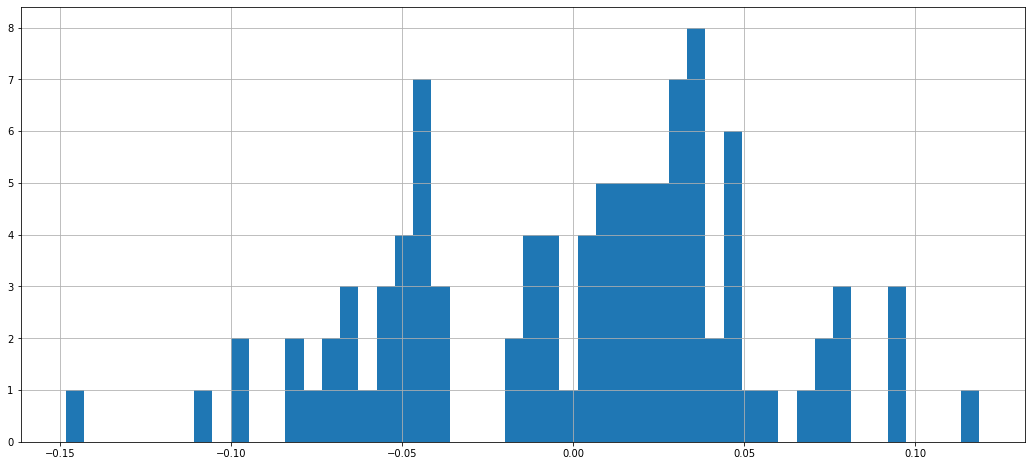

In [37]:
Backtest_BTC_stop['profit'].hist(figsize=(18, 8), bins=50);

/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


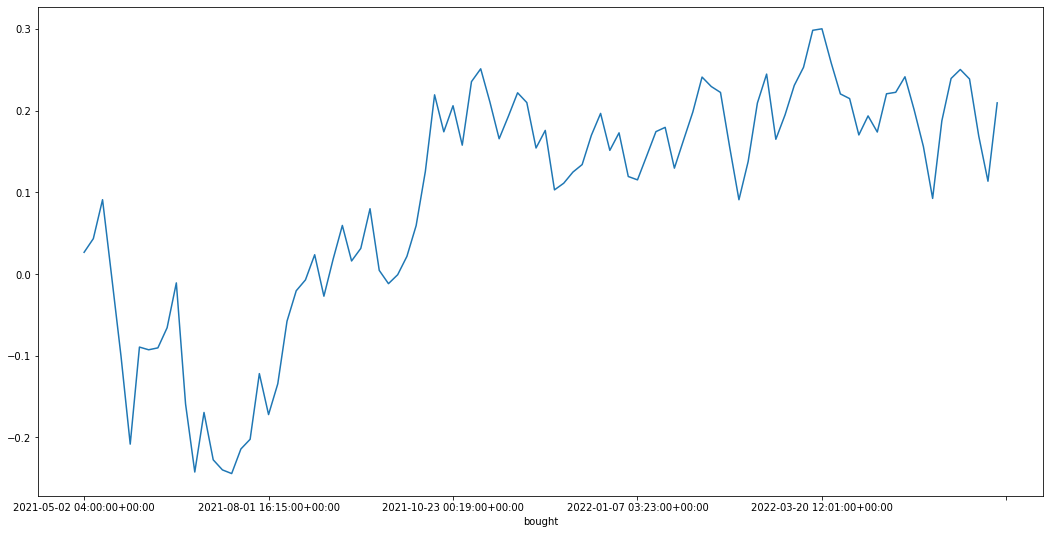

In [38]:
Backtest_BTC_stop['profit'].cumsum().plot(figsize=(18, 9));

In [ ]:
Backtest_BTC_stop = backtest(data.index[0], data.index[-1], predictive_period=pd.Timedelta(hours=2))

		Simulating 2021-05-01 00:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 52640.75261456766, actual: 57421.05
Predicted buy: 56314.73635850582, actual: 57931.89
Predicted buy: 56314.73635850582, actual: 57687.04
Predicted buy: 56314.73635850582, actual: 57585.55
Predicted buy: 56314.73635850582, actual: 57116.16
Predicted buy: 56314.73635850582, actual: 57335.75
Predicted buy: 56314.73635850582, actual: 57525.0
Predicted buy: 56314.73635850582, actual: 56956.14
Predicted buy: 56314.73635850582, actual: 57218.0
Predicted buy: 56314.73635850582, actual: 57400.35
Predicted buy: 56314.73635850582, actual: 57372.01
Predicted buy: 56314.73635850582, actual: 57243.65
Predicted buy: 56314.73635850582, actual: 57275.0
Predicted buy: 55831.119781361835, actual: 56323.66
Predicted buy: 55831.119781361835, actual: 56171.31
Predicted buy: 55831.119781361835, actual: 56404.31
Predicted buy: 55831.119781361835, actual: 56035.25
Predicted buy: 55831.119781361835, actual: 56385.16
Predicted buy: 55831.119781361835, actual: 56451.01
Predicted buy: 55831.1197813

/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 57100.57772185521, actual: 56012.49
Predicted sell: 57100.57772185521, actual: 56291.37
Predicted sell: 57100.57772185521, actual: 56361.82
Predicted sell: 57100.57772185521, actual: 56399.68
Predicted sell: 57100.57772185521, actual: 56637.89
Predicted sell: 57100.57772185521, actual: 56321.18
Predicted sell: 57100.57772185521, actual: 55552.85
Predicted sell: 57100.57772185521, actual: 54315.57
Predicted sell: 57100.57772185521, actual: 54745.81
Predicted sell: 57100.57772185521, actual: 54824.0
Predicted sell: 57100.57772185521, actual: 54427.0
Predicted sell: 57100.57772185521, actual: 55098.0
Predicted sell: 57972.52200035217, actual: 55415.83
Predicted sell: 57972.52200035217, actual: 55285.71
Predicted sell: 57972.52200035217, actual: 55028.21
Predicted sell: 57972.52200035217, actual: 55555.0
Predicted sell: 57972.52200035217, actual: 55809.24
Predicted sell: 57972.52200035217, actual: 56259.74
Predicted sell: 57972.52200035217, actual: 57712.06
Predicted sell: 

/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 52704.87950476773, actual: 54659.0
Predicted buy: 52704.87950476773, actual: 54276.0
Predicted buy: 52704.87950476773, actual: 53922.84
Predicted buy: 52704.87950476773, actual: 54679.13
Predicted buy: 52704.87950476773, actual: 55000.0
Predicted buy: 52704.87950476773, actual: 55032.65
Predicted buy: 52704.87950476773, actual: 55659.69
Predicted buy: 52704.87950476773, actual: 57198.03
Predicted buy: 52704.87950476773, actual: 57043.0
Predicted buy: 52704.87950476773, actual: 56576.04
Predicted buy: 52704.87950476773, actual: 56715.3
Predicted buy: 52704.87950476773, actual: 56570.66
Predicted buy: 54744.66301375414, actual: 56632.65
Predicted buy: 54744.66301375414, actual: 56700.0
Predicted buy: 54744.66301375414, actual: 56331.66
Predicted buy: 54744.66301375414, actual: 56772.75
Predicted buy: 54744.66301375414, actual: 57150.0
Predicted buy: 54744.66301375414, actual: 57051.96
Predicted buy: 54744.66301375414, actual: 56763.0
Predicted buy: 54744.66301375414, actua

/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted sell: 59433.97139404371, actual: 59444.9
Sold BTC by 59433.97139404371 at 2021-05-10 03:34:00+00:00
		Simulating 2021-05-10 02:00:00+00:00 day....


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Predicted buy: 53569.26636154183, actual: 58650.39
Predicted buy: 53569.26636154183, actual: 58680.26
Predicted buy: 53569.26636154183, actual: 58355.79
Predicted buy: 53569.26636154183, actual: 57736.46
Predicted buy: 53569.26636154183, actual: 57301.81
Predicted buy: 53569.26636154183, actual: 57455.0
Predicted buy: 53569.26636154183, actual: 56700.0
Predicted buy: 53569.26636154183, actual: 56849.75
Predicted buy: 53569.26636154183, actual: 55516.85
Predicted buy: 53569.26636154183, actual: 53400.0
stop_loss = 48407.06203292374
Bought BTC by 53569.26636154183 at 2021-05-10 20:05:00+00:00


/home/olga/PycharmProjects/backtesting/venv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [ ]:
Backtest_BTC_stop_2h = pd.read_csv('backtest_Theta_stop.csv', index_col='bought')
Backtest_BTC_stop_2h